In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import seaborn as sb
pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv(r"./bbc.csv")

In [3]:
df.shape

(12456, 20)

Q: Types of data that are present in the dataset
A: There seems to be 1: bool, 4: float64, 5: int64, 10: object types in the dataset


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12456 entries, 0 to 12455
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   position              12456 non-null  int64  
 1   channel_id            12456 non-null  object 
 2   channel_title         12456 non-null  object 
 3   video_id              12456 non-null  object 
 4   published_at          12456 non-null  object 
 5   video_title           12456 non-null  object 
 6   video_description     12456 non-null  object 
 7   video_category_id     12456 non-null  int64  
 8   video_category_label  12456 non-null  object 
 9   duration              12456 non-null  object 
 10  duration_sec          12456 non-null  int64  
 11  dimension             12456 non-null  object 
 12  definition            12456 non-null  object 
 13  caption               12456 non-null  bool   
 14  licensed_content      11878 non-null  float64
 15  view_count         

Q: What is the minimum and maximum value for a published time header (‘parsed_time_pub’)? Present it in a year (YYYY) format.

In [5]:
df["published_at"] = pd.to_datetime(df["published_at"])
max_value = df["published_at"].max().year
min_value = df["published_at"].min().year
print(f"The maximum and minimum value for a published time header in (YYYY) format are {max_value}, {min_value}")



The maximum and minimum value for a published time header in (YYYY) format are 2020, 2007


Q What are the 5 most popular video categories of all time? Please visualize the result

In [6]:
def top_x_categories(df, x):
    """df: Dataframe to be processed
        x: integer, how many top categories are to be selected"""
    if x < len(df["video_category_label"].unique()):
        temp_df_view = df.groupby(by="video_category_label")["view_count"].agg('sum').sort_values(ascending=False).reset_index()[:x]
        temp_df_like = df.groupby(by="video_category_label")["like_count"].agg('sum').sort_values(ascending=False).reset_index()[:x]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 8))
        fig.suptitle('Top Video Categories')

        video_category = temp_df_view["video_category_label"]
        view_count = temp_df_view["view_count"]
        ax1.bar(video_category, view_count)
        ax1.title.set_text("By View Count")
        ax1.tick_params(axis='x', labelrotation=40)
        
        video_category = temp_df_like["video_category_label"]
        like_count = temp_df_like["like_count"]
        ax2.bar(video_category, like_count)
        ax2.title.set_text("By Like Count")
        ax2.tick_params(axis='x', labelrotation=40)


        # plt.show()
    else:
        print("please select fewer number of categories")



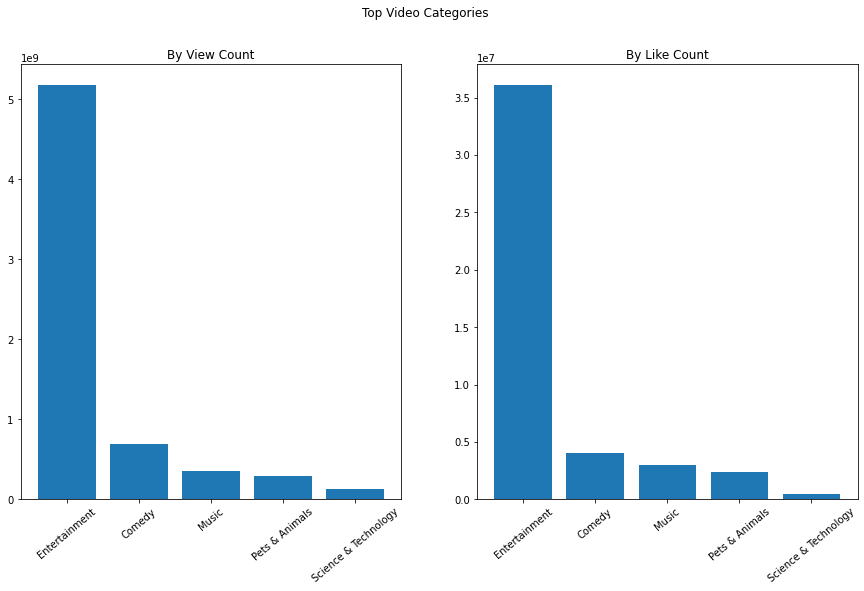

In [7]:
top_x_categories(df, 5)

Q: Slice the dataset by cutting the following columns:
published_at, video_category_id, duration, dimension, licensed_content, favorite_count.

In [8]:
col_required = ['published_at', 'video_category_id', 'duration','dimension', 'licensed_content', 'favorite_count']
sliced_df = df[col_required]
sliced_df.head()

,published_at,video_category_id,duration,dimension,licensed_content,favorite_count
0,2020-08-13 15:00:02+00:00,24,PT5M23S,2d,1.0,0
1,2020-08-13 14:30:04+00:00,24,PT3M15S,2d,1.0,0
2,2020-08-13 05:50:21+00:00,27,PT14M48S,2d,NaN,0
3,2020-08-12 13:00:13+00:00,27,PT3M50S,2d,1.0,0
4,2020-08-12 11:00:02+00:00,24,PT1M52S,2d,1.0,0


Q: From the column 'video_title' create a new header 'video_title_clean' by:
-	Removing punctuation;
-	Removing stopwords;
-	Removing digits;
-	Removing following strings: ‘bbc one’, ‘bbc two’, 'bbc three’, ‘bbc’, ‘part’, ‘episode’, ‘series’, ‘preview’, ‘show’.


In [9]:
keyword_list = ["bbc one","bbc two","bbc three", "bbc","part","episode","series","preview","show","\d+"] # keywords to be removed
search_pattern = re.compile("|".join(r"\b{}\b".format(x) for x in keyword_list))

def clean_text(x):
    stop_words = stopwords.words('english')
    x = str(x).lower().strip()
    x_no_punct = str(x).translate(str.maketrans('', '', string.punctuation)) # remove punctuations
    x_no_keywords = re.sub(search_pattern, "", x_no_punct) # removes keywords and digits 
    tokens = word_tokenize(x_no_keywords)
    no_stopword = [word for word in tokens if word not in stop_words] # removes stpowords

    return " ".join(no_stopword)
    
    

In [10]:
df["video_title_clean"] = df["video_title"].apply(lambda x: clean_text(x))


Q: Find the top 5 keywords from the newly generated ‘video_title_clean’ header for each year represented in the dataset.

In [11]:
df["published_at_year"] = df["published_at"].apply(lambda x: x.year)


In [12]:
df_keyword_year = df.groupby(by= ["published_at_year"])["video_title_clean"].apply(lambda x: " ".join(x)).reset_index()

In [13]:
def get_word_count(text, x):
    """
    text: the text from which the top keywords are to be extracted
    x: integer, how many top keywords are to be extracted
    """
    tokens = word_tokenize(text)
    count = {}
    for word in word_tokenize(text):
        if word in count:
            count[word] += 1
        else:
            count[word] = 1
    final_dict = sorted(count.items(), key=lambda x:x[1], reverse= True)[:x]

    return final_dict

In [14]:
df_keyword_year["top_keywords"] = df_keyword_year["video_title_clean"].apply(lambda x: get_word_count(x, 5))

In [15]:
df_keyword_year

,published_at_year,video_title_clean,top_keywords
0,2007,kevins joyride eastenders russell brands raunc...,"[(strictly, 37), (dancing, 37), (come, 36), (r..."
1,2008,london fireworks new years day new year live s...,"[(dancing, 113), (strictly, 112), (come, 111),..."
2,2009,hip hop think dance auditions think dance surv...,"[(week, 103), (night, 88), (jonathan, 86), (ro..."
3,2010,jonathan ross sees constellations stargazing l...,"[(rainbow, 135), (dance, 113), (week, 104), (e..."
4,2011,original british drama pips mystery benefactor...,"[(song, 101), (graham, 96), (eurovision, 96), ..."
5,2012,close encounter polar bear polar bear family m...,"[(voice, 203), (uk, 197), (come, 139), (dancin..."
6,2013,dolphin megapod filmed first time dolphins spy...,"[(voice, 212), (uk, 199), (come, 155), (strict..."
7,2014,grape eating contest mock week christmas ella ...,"[(voice, 215), (uk, 204), (performs, 157), (gl..."
8,2015,making victorian london sherlock abominable br...,"[(jools, 109), (holland, 104), (graham, 100), ..."
9,2016,helga james brothel taboo tvs famous chair gra...,"[(graham, 101), (norton, 100), (–, 38), (micha..."


Q Calculate and assign a new column 'engagement rate' for each row using the following formula: total engagements (likes, comments, dislikes) divided by the number of views per post, then multiply the result by 100 and round it up to 1 decimal.

In [16]:
def get_engagement_rate(row):
    numerator = row["like_count"] + row["comment_count"] + row["dislike_count"]
    denominator = row["view_count"]
    score = round(((numerator/denominator) * 100), 1)
    return score

In [17]:
df["engagement_rate"] = df.apply(lambda row: get_engagement_rate(row), axis=1)

Q Calculate the length of characters in ‘video_title_clean’ and assign it to ‘title_len’ column.

In [18]:
df["title_len"] = df["video_title_clean"].apply(lambda x: len(str(x)))

Q Assign a dichotomized score for engagement rate in a separate column, where  ‘top 50%’  (engagement rate >=0.6) is represented by 1 , and ‘bottom 50%’ is represented by 0.

In [19]:
df["engagement_rate_top_50%"] = df["engagement_rate"].apply(lambda x: 1 if x >= 60 else 0)

Q Encode ‘video category’ labels and ‘definition’ labels to numeric values

Converting the variables in to ordinal categarical variables:
HD is better than SD hence receives a higher number
For video category label, it has been grouped by view count and high view count categories have received a higher number. 

In [20]:
video_category_mapping = df.groupby(by="video_category_label")["view_count"].agg('sum').sort_values(ascending=True).reset_index()
video_category_mapping["video_category_ordinal"] = video_category_mapping["view_count"].rank(ascending = True)
video_category_mapping["video_category_ordinal"] = video_category_mapping["video_category_ordinal"].astype('int')

In [21]:
df["definition_ordinal"] = df["definition"].apply(lambda x: 2 if x=="hd" else 1)

In [22]:
df = df.merge(video_category_mapping[["video_category_label", "video_category_ordinal"]], how= 'left', left_on = "video_category_label", right_on = "video_category_label")

Q Visualize a correlation between following headers:
definition, duration, dichotomized score, parsed_time_pub, engagement rate, title length, video_category_label.


In [23]:
corr_fields = ["definition_ordinal", "duration_sec",  "engagement_rate","published_at_year", "title_len", "video_category_ordinal", "view_count"] #"engagement_rate_top_50%",
df_corr = df[corr_fields]

<AxesSubplot:>

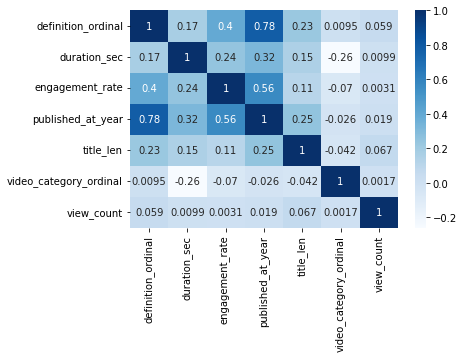

In [24]:
corr = df_corr.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

Comments:
- Removed dichotomized score from correlation calculation because none of the values for engagement rate was >= 60% and hence it was all zeros.
- Positive correlation, which means that both variables move in the same direction. I.e. an increase in one variable is followed by an increase in the other variable:
    - Strong Correlation ( x >=0.75): It is seen that "published_at_year" has a strong positive correlation with "definition_ordinal" 0.78. Which means that as the number of years passed increases the number of HD videos uploaded on the BBC YouTube channel has also increases. This can be due to usage of better-quality cameras to record the videos or technological advancements on the YouTube Platform to support HD videos.
    - Moderate correlation (0.4< x < 0.75): It is seen that "published_at_year" has a moderate positive correlation with "engagement_rate" 0.56. Which means as number of years passed increases the rate of engagement on the platform also increases. This may indicate that as time as passed the engagement rate for the BCC channel has increased. This will need further investigation to check for the cause of this rise in engagement. It may be marketing efforts from BBC or Internet becoming widely available which might have increased the number of users on YouTube and thus increasing engagement on the platform as a whole.
    Another obseravtion is that the as "definition_ordinal" increases the "engagement_rate" 0.4 also increases. Which means that as the quality of the video uploaded increases the engagement also increases. Again further investigation must be done to check this relationship.
    - Weak correlation (0 < x < 0.4): It can be seen that 
        - “title_len” and “definition_ordinal” 0.23 higher the character lenght of the title, higher the quality of the video
        - "published_at_year" and "title_len" 0.25 higher the published year, higher the character lenght of the title
        - "publihsed_at_year" and "duration_sec" 0.32 higher the published year, higher the duration of the video
        - "engagement_rate" and "duration_sec" 0.24 higher the duration of the video, higher the engagement rate.

- Negative correlation, which means that both variables move in the opposite direction. I.e. an increase in one variable is followed by a decrease in the other variable:
    - Weak Correlation (-0.4 < x < 0): "duration_sec" and "video_category_ordinal" -0.26. Meaning as the duration of a video increases "video_category_ordinal" decreases. Meaning as durations of a video increases, the view count of a video decreases. Becases video_category_ordinal" has been encoded in such a way that videos with higher view count have a higher number and vice-versa. 

Note: None of the correlations between the variables indicate any causation. To check if an increase in one variable causes the other to increase further analysis must be done. 